<a href="https://colab.research.google.com/github/ElektrosStulpas/QuantumRNN-BachelorsVU/blob/main/QRNNimplementationEightDayGradEverySample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and import needed libraries

In [ ]:
!pip install qiskit[visualization]

In [ ]:
from google.colab import drive
import pandas as pd
import os
import yfinance as yf
import random
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi
import numpy as np
import matplotlib.pyplot as plt

Interaction with google drive and loading stock data

In [ ]:
def connect_google_drive():
  drive.mount('/content/drive')

def save_and_disconnect_google_drive():
  drive.flush_and_unmount()

In [ ]:
ROOT_PATH = "/content/drive/MyDrive/QRNNData"
STOCK_DATA_FOLDER = "StockData"

def save_stock_data_to_drive(df, data_file_name):
  df.to_csv(os.path.join(ROOT_PATH, STOCK_DATA_FOLDER, data_file_name))

def load_stock_data_from_drive(data_file_name):
  data_frame = pd.read_csv(os.path.join(ROOT_PATH, STOCK_DATA_FOLDER, data_file_name))
  return data_frame

def load_stock_data_from_yahoo_finance(ticker, interval="1d", period="1y"):
  data_frame = yf.download(ticker, period=period, interval=interval)
  return data_frame

In [ ]:
#Functions to save and load params (np.array) from and to drive
PARAMS_FOLDER = "Params"

def save_params_to_drive(params_to_save, model_type, ticker, metric, epochs_num):
  np.save(os.path.join(ROOT_PATH, PARAMS_FOLDER, f"{model_type}_{ticker}_{metric}_{epochs_num}epochs_params"), params_to_save)

def load_params_from_drive(file_name):
  return np.load(os.path.join(ROOT_PATH, PARAMS_FOLDER, file_name))

In [ ]:
connect_google_drive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Run this once to download the stock data and save to drive for reproducible testing

# BKNG_data = load_stock_data_from_yahoo_finance("BKNG")
# SPY_data = load_stock_data_from_yahoo_finance("SPY")
# TUP_data = load_stock_data_from_yahoo_finance("TUP")

# save_stock_data_to_drive(BKNG_data, "BKNG_data.csv")
# save_stock_data_to_drive(SPY_data, "SPY_data.csv")
# save_stock_data_to_drive(TUP_data, "TUP_data.csv")

In [ ]:
BKNG_data = load_stock_data_from_drive("BKNG_data.csv")
SPY_data = load_stock_data_from_drive("SPY_data.csv")
TUP_data = load_stock_data_from_drive("TUP_data.csv")

In [ ]:
BKNG_data.index = BKNG_data["Date"]
BKNG_data.head()

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-05-13  2104.300049  2124.989990  2072.209961  2101.889893  2101.889893   
2022-05-16  2086.110107  2094.590088  2033.609985  2046.010010  2046.010010   
2022-05-17  2125.000000  2161.000000  2109.860107  2146.590088  2146.590088   
2022-05-18  2120.000000  2134.060059  2042.000000  2050.379883  2050.379883   
2022-05-19  2059.620117  2142.429932  2042.579956  2103.399902  2103.399902   

            Volume  
Date                
2022-05-13  301900  
2022-05-16  289300  
2022-05-17  407100  
2022-05-18  360500  
2022-05-19  387200

In [ ]:
SPY_data.index = SPY_data["Date"]
SPY_data.head()

Date        Open        High         Low       Close  \
Date                                                                     
2022-05-13  2022-05-13  396.709991  403.179993  395.609985  401.720001   
2022-05-16  2022-05-16  399.980011  403.970001  397.600006  400.089996   
2022-05-17  2022-05-17  406.529999  408.570007  402.579987  408.320007   
2022-05-18  2022-05-18  403.500000  403.799988  390.549988  391.859985   
2022-05-19  2022-05-19  388.619995  394.140015  387.109985  389.459991   

             Adj Close     Volume  
Date                               
2022-05-13  395.027252  104174400  
2022-05-16  393.424408   78622400  
2022-05-17  401.517303   83029700  
2022-05-18  385.331512  117674500  
2022-05-19  382.971497   98510700

In [ ]:
TUP_data.index = TUP_data["Date"]
TUP_data.head()

Date  Open  High   Low  Close  Adj Close   Volume
Date                                                               
2022-05-13  2022-05-13  6.95  7.52  6.92   7.24       7.24  2445500
2022-05-16  2022-05-16  7.25  7.35  6.75   6.86       6.86  1957200
2022-05-17  2022-05-17  7.01  7.21  6.86   7.10       7.10  1573700
2022-05-18  2022-05-18  7.00  7.00  6.25   6.33       6.33  2839700
2022-05-19  2022-05-19  6.25  6.36  5.98   6.16       6.16  1898400

Data preparation

In [ ]:
#data normalization
def rescale_data(data, new_scale_from, new_scale_to):
  #GENERAL NORMALIZATION FORMULA from https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1
  rescaled_x = (new_scale_to-new_scale_from) * ((data - DATA_MAXMIN[1]) / ( DATA_MAXMIN[0] - DATA_MAXMIN[1])) + new_scale_from

  return rescaled_x

In [ ]:
def calculate_data_range(data_array):
  return max(data_array), min(data_array)

def generate_datasets(df_column, train_len, valid_len, sequence_size=7):
  valid_len = train_len + valid_len # since valid len is used as the upper bound

  inputs_TRAIN = rescale_data(df_column, -1, 1)[:train_len]
  # inputs_TRAIN = df_column[:train_len]
  labels_TRAIN = df_column[:train_len+1] # taking one more to include one value past the end so we can naturally shift it without losing length

  inputs_VALID = rescale_data(df_column, -1, 1)[train_len:valid_len]
  labels_VALID = df_column[train_len:valid_len+1] # taking one more to lengthen the array so we can naturally shift it without losing length

  valid_index = labels_VALID.index # save index for plotting data later

  inputs_TRAIN = np.array([inputs_TRAIN[i:i+sequence_size] for i in range(len(inputs_TRAIN) - sequence_size+1)])
  labels_TRAIN = np.array(labels_TRAIN[sequence_size:]) # sequence_size shifts the data naturally
  training_data = list(zip(inputs_TRAIN, labels_TRAIN))

  inputs_VALID = np.array([inputs_VALID[i:i+sequence_size] for i in range(len(inputs_VALID) - sequence_size+1)])
  labels_VALID = np.array(labels_VALID[sequence_size:]) # sequence_size shifts the data naturally
  validation_data = list(zip(inputs_VALID, labels_VALID))

  return training_data, validation_data, valid_index

In [ ]:
#CAN CHANGE DATA SERIES INPUT HERE
stock_data = BKNG_data["Close"]

DATA_MAXMIN = calculate_data_range(stock_data)

# In the work we're following they mention using 100 data points for training and 80 for test
train_dataset, valid_dataset, valid_index = generate_datasets(stock_data, train_len=100, valid_len=80)

SAMPLE_NUM_TRAIN = len(train_dataset)
SAMPLE_NUM_VALID = len(valid_dataset)

In [ ]:
for input, label in train_dataset[:4]:
  print(f"{input} {label}")

[-0.13581913 -0.2391626  -0.05315122 -0.23108102 -0.13302654 -0.10990922
 -0.12701604] 2050.06005859375
[-0.2391626  -0.05315122 -0.23108102 -0.13302654 -0.10990922 -0.12701604
 -0.23167249] 2147.219970703125
[-0.05315122 -0.23108102 -0.13302654 -0.10990922 -0.12701604 -0.23167249
 -0.05198632] 2221.510009765625
[-0.23108102 -0.13302654 -0.10990922 -0.12701604 -0.23167249 -0.05198632
  0.08540463] 2265.97998046875


In [ ]:
for input, label in valid_dataset[:4]:
  print(f"{input} {label}")

[-0.86107414 -0.90651345 -0.9320906  -1.         -0.92415667 -0.89362329
 -0.93364403] 1747.489990234375
[-0.90651345 -0.9320906  -1.         -0.92415667 -0.89362329 -0.93364403
 -0.79124131] 1773.9599609375
[-0.9320906  -1.         -0.92415667 -0.89362329 -0.93364403 -0.79124131
 -0.74228812] 1771.8199462890625
[-1.         -0.92415667 -0.89362329 -0.93364403 -0.79124131 -0.74228812
 -0.74624583] 1773.6199951171875


In [ ]:
print(f"train_dataset len: {len(train_dataset)}, valid_dataset len: {len(valid_dataset)}")

train_dataset len: 94, valid_dataset len: 74


Model

In [ ]:
from enum import Enum

class ModelType(Enum):
  PLAIN = 1
  STAG = 2

In [ ]:
class QRNN():
  def __init__(self, q_reg, params, model_type):
    self.qubits_per_reg = q_reg
    self.model_type = model_type

    if params is not None:
      self.params = params
    else:
       self.params = self.init_random_params()

    self.ansatz = self.construct_ansatz()


  def get_model_type(self):
    return self.model_type

  def set_params(self, params):
    self.params = params
    self.ansatz = self.construct_ansatz()

  def get_params(self):
    return self.params


  def construct_enc_circ(self, x_val):
    enc_circ = QuantumCircuit(self.qubits_per_reg)

    for qubit in range(self.qubits_per_reg):
      enc_circ.ry(np.arccos(x_val), qubit)

    return enc_circ


  def construct_ansatz(self):
    theta_gamma_params = self.params

    ansatz = QuantumCircuit(self.qubits_per_reg*2)

    qu_indexes = list(range(self.qubits_per_reg*2))
    qu_indexes_rolled = list(range(1, self.qubits_per_reg*2))
    qu_indexes_rolled.append(0)

    for idx in qu_indexes:
      ansatz.rx(theta_gamma_params[idx][0], idx)
      ansatz.rz(theta_gamma_params[idx][1], idx)
      ansatz.rx(theta_gamma_params[idx][2], idx)

    for idx in qu_indexes:
      ansatz.cnot(idx, qu_indexes_rolled[idx])
      ansatz.rz(theta_gamma_params[idx][3], qu_indexes_rolled[idx])
      ansatz.cnot(idx, qu_indexes_rolled[idx])

    return ansatz


  def partial_trace_measure(self, circuit, qubit_to_measure):
    circ_dens_matrix = qi.DensityMatrix.from_instruction(circuit)
    qubits_to_trace_out = list(range(self.qubits_per_reg*2))
    qubits_to_trace_out.remove(qubit_to_measure)

    measured_qubit_rho = qi.partial_trace(circ_dens_matrix, qubits_to_trace_out)

    ket1 = qi.Statevector([0, 1])
    projector1 = ket1.to_operator()

    trimmed_measured_qubit_rho = measured_qubit_rho.evolve(projector1)
    prediction_y = trimmed_measured_qubit_rho.trace()

    return prediction_y
    

  def init_random_params(self):
    rng = np.random.default_rng()
    theta_gamma_params = np.arccos(rng.uniform(-1, 1, size=(self.qubits_per_reg*2, 4))) #6x3 theta params and 6x1 gamma params
    return theta_gamma_params

In [ ]:
class pQRNN(QRNN):
  def __init__(self, q_reg=3, params=None):
    super().__init__(q_reg, params, ModelType.PLAIN)


  #takes input vector of value from -1 to 1, outputs prediction in range 0 to 1
  def forward(self, x_vec):
    QRNN_circuit = QuantumCircuit(self.qubits_per_reg*2)

    QRNN_circuit.reset(list(range(self.qubits_per_reg*2)))

    for idx in range(7):
      QRNN_circuit.reset(list(range(self.qubits_per_reg)))
      encoding_circ = self.construct_enc_circ(x_vec[idx])
      QRNN_circuit.compose(encoding_circ, list(range(self.qubits_per_reg)), inplace=True)

      QRNN_circuit.compose(self.ansatz, inplace=True, wrap=True)

    y_t = self.partial_trace_measure(QRNN_circuit, 0)

    return abs(y_t) # don't need to square this because the probability comes from the density matrix, which already holds squared values


In [ ]:
class sQRNN(QRNN):
  def __init__(self, q_reg=3, params=None):
    super().__init__(q_reg, params, ModelType.STAG)


  #takes input vector of value from -1 to 1, outputs prediction in range 0 to 1
  def forward(self, x_vec):
    QRNN_circuit = QuantumCircuit(self.qubits_per_reg*2)

    QRNN_circuit.reset(list(range(self.qubits_per_reg*2)))

    measure_qubit = None

    for idx in range(7):
      reg_d_list = [(idx+i)%(self.qubits_per_reg*2) for i in range(self.qubits_per_reg)]
      measure_qubit = reg_d_list[1]

      QRNN_circuit.reset(reg_d_list)
      encoding_circ = self.construct_enc_circ(x_vec[idx])
      QRNN_circuit.compose(encoding_circ, reg_d_list, inplace=True)

      QRNN_circuit.compose(self.ansatz, inplace=True, wrap=True)

    y_t = self.partial_trace_measure(QRNN_circuit, measure_qubit)

    return abs(y_t)# don't need to square this because the probability comes from the density matrix, which already holds squared values


In [ ]:
# model = sQRNN_ALT()
# circuit = None

# for input, label in train_dataset[:4]:
#   print(f"{input} {label}")
#   pred, circuit = model.forward(input)

# circuit.draw('mpl')

In [ ]:
# generating random params and saving it to be reused so it would be easier to measure performance with different hyper-parameters

# model = QRNN()
# save_params_to_drive(root_path, "6_qubit_params", model.get_params())

Sanity check that the ansatz gets assigned the correct values

In [ ]:
qubit_num = 6
rng = np.random.default_rng()
theta_gamma_params = np.arccos(rng.uniform(-1, 1, size=(qubit_num, 4)))

print(theta_gamma_params)

qu_indexes = list(range(qubit_num))
qu_indexes_rolled = list(range(1, qubit_num))
qu_indexes_rolled.append(0)

for idx in qu_indexes:
  print(f"RX: {theta_gamma_params[idx][0]}, RZ: {theta_gamma_params[idx][1]}, RX: {theta_gamma_params[idx][2]} for qubit {idx}")

for idx in qu_indexes:
  print(f"RZ: {theta_gamma_params[idx][3]} gamma on qubit {qu_indexes_rolled[idx]}")

[[0.9337007  2.4271544  1.68310553 1.88320506]
 [2.10316503 1.87322942 2.28393014 1.06152146]
 [0.39866424 0.62746381 1.66568297 1.36345576]
 [1.22880627 3.04763213 1.98927689 1.44352773]
 [2.39674981 2.34218688 1.81122665 1.81890378]
 [1.18959469 0.26706329 1.27076327 1.69481823]]
RX: 0.9337007007016903, RZ: 2.4271544013513413, RX: 1.6831055323072894 for qubit 0
RX: 2.103165028486027, RZ: 1.873229417641781, RX: 2.283930136561462 for qubit 1
RX: 0.39866423765393527, RZ: 0.6274638131729021, RX: 1.6656829700533995 for qubit 2
RX: 1.2288062655916807, RZ: 3.0476321339100036, RX: 1.9892768871656825 for qubit 3
RX: 2.396749808989695, RZ: 2.3421868808698396, RX: 1.8112266453665837 for qubit 4
RX: 1.1895946916834346, RZ: 0.26706329298658965, RX: 1.270763272347617 for qubit 5
RZ: 1.8832050570340562 gamma on qubit 1
RZ: 1.0615214633781709 gamma on qubit 2
RZ: 1.363455758790074 gamma on qubit 3
RZ: 1.4435277310593981 gamma on qubit 4
RZ: 1.8189037822148384 gamma on qubit 5
RZ: 1.6948182294233305 

TRAINING

In [ ]:
def L2_loss(prediction, true_val, sample_num):
  loss = ((prediction-true_val)**2) / sample_num
  return loss

In [ ]:
def prediction_accuracy(predicted, actual):
  E_vec = (actual-predicted) / actual

  #Original accuracy formula presented in the work, Root Mean Squared Error (RMSE)
  accuracy = (1-np.mean(E_vec**2)**0.5) * 100
  return accuracy

In [ ]:
def postprocess_output(output):
  return output * (DATA_MAXMIN[0]-DATA_MAXMIN[1]) + DATA_MAXMIN[1]

In [ ]:
def gradient_descent(model_type, params, input, label, perturbation=0.001, lr=0.03):
  params_1d = np.reshape(params, -1)
  len_params = len(params_1d)
  gradients = np.zeros(len_params)

  #for every parameter
  for idx in range(len_params):
    #generate index vector
    e_vec = np.zeros(len_params)
    e_vec[idx] = 1

    #generate params with finite diff to both sides
    params_1d_plus = params_1d + perturbation*e_vec
    params_plus = np.reshape(params_1d_plus, params.shape)
    params_1d_minus = params_1d - perturbation*e_vec
    params_minus = np.reshape(params_1d_minus, params.shape)

    #create QRNNs with the finite difference params
    if model_type == ModelType.PLAIN:
      QRNN_plus = pQRNN(params=params_plus)
      QRNN_minus = pQRNN(params=params_minus)
    elif model_type == ModelType.STAG:
      QRNN_plus = sQRNN(params=params_plus)
      QRNN_minus = sQRNN(params=params_minus)
    else:
      print(f"Unknown model type: {model_type}")

    # run forward pass to get predictions 
    prediction_plus = postprocess_output(QRNN_plus.forward(input))
    prediction_minus = postprocess_output(QRNN_minus.forward(input))

    # calculate gradient for this parameter
    gradients[idx] = (L2_loss(prediction_plus, label, SAMPLE_NUM_TRAIN)-L2_loss(prediction_minus, label, SAMPLE_NUM_TRAIN)) / (2*perturbation)

  #apply gradients to parameters and return the updated parameters
  params_1d = params_1d - gradients*lr

  return np.reshape(params_1d, params.shape)


In [ ]:
def after_epoch_validation(model, validation_data):

  # random.shuffle(validation_data)
  losses = []
  predictions = []
  labels = []

  for input, label in validation_data:
    labels.append(label)

    prediction = postprocess_output(model.forward(input))
    predictions.append(prediction)

    loss = L2_loss(prediction, label, SAMPLE_NUM_VALID)
    losses.append(loss)

  avg_loss = np.mean(losses)
  accuracy = prediction_accuracy(np.array(predictions), np.array(labels))

  print(f"Validation loss: {avg_loss:.2f}, validation accuracy: {accuracy:.2f}")

  return np.array(predictions), np.array(labels)

In [ ]:
def training(model, training_data, validation_data, epochs_num):

  predictions_and_labels_epochs = []

  for epoch in range(epochs_num):
    # random.shuffle(training_data)
    losses = []
    predictions = []
    labels = []

    for input, label in training_data:
      labels.append(label)

      prediction = model.forward(input)
      prediction = postprocess_output(prediction)

      predictions.append(prediction)

      loss = L2_loss(prediction, label, SAMPLE_NUM_TRAIN)
      losses.append(loss)

      updated_params = gradient_descent(model.get_model_type(), model.get_params(), input, label)
      model.set_params(updated_params)

      if len(losses)%5 == 0:
        print(f"Average running loss: {np.mean(losses):.2f} Average running accuracy: {prediction_accuracy(np.array(predictions), np.array(labels)):.2f}")
        print("=====================================")

    avg_loss = np.mean(losses)
    accuracy = prediction_accuracy(np.array(predictions), np.array(labels))
    print(f"\nEpoch {epoch+1} / {epochs_num}: Loss = {avg_loss:.2f}, Accuracy: {accuracy:.2f}\n")

    predictions_and_labels_epochs.append((predictions, labels))

    # after_epoch_validation(model, validation_data)

  return model, np.array(predictions_and_labels_epochs)



TRAINING the model

In [ ]:
loaded_params = load_params_from_drive("6_qubit_params")
print(loaded_params)

[[1.71844876 2.04838708 1.65311667 0.46461651]
 [1.12144523 1.17159783 1.71884063 1.26738357]
 [0.91594512 1.86570833 1.94842573 0.57828036]
 [1.17263427 2.53478912 1.10382683 1.90555317]
 [1.43265092 0.9580048  1.75344986 1.34060377]
 [0.98705363 0.61479902 1.85558472 0.53640413]]


In [ ]:
trained_model_sQRNN, epochs_training_progress_sQRNN = training(sQRNN(params=loaded_params), train_dataset, valid_dataset, 1)

save_params_to_drive(trained_model_sQRNN.get_params(), "sQRNN", "BKNG", "Close", "1")

Average running loss: 1152.15 Average running accuracy: 84.73
Average running loss: 1316.14 Average running accuracy: 84.32
Average running loss: 1132.10 Average running accuracy: 85.09
Average running loss: 1184.00 Average running accuracy: 84.21
Average running loss: 1078.08 Average running accuracy: 84.70
Average running loss: 1175.73 Average running accuracy: 83.35
Average running loss: 1680.82 Average running accuracy: 78.78
Average running loss: 1653.99 Average running accuracy: 78.77
Average running loss: 1812.70 Average running accuracy: 77.74
Average running loss: 1749.83 Average running accuracy: 78.20
Average running loss: 1781.38 Average running accuracy: 78.16
Average running loss: 1692.18 Average running accuracy: 78.80
Average running loss: 1699.54 Average running accuracy: 78.84
Average running loss: 1672.89 Average running accuracy: 79.01
Average running loss: 1699.96 Average running accuracy: 78.81
Average running loss: 1724.38 Average running accuracy: 78.69
Average 

In [ ]:
trained_model_pQRNN, epochs_training_progress_pQRNN = training(pQRNN(params=loaded_params), train_dataset, valid_dataset, 1)

save_params_to_drive(trained_model_pQRNN.get_params(), "pQRNN", "BKNG", "Close", "1")

Average running loss: 914.57 Average running accuracy: 86.23
Average running loss: 1476.15 Average running accuracy: 83.65
Average running loss: 1401.68 Average running accuracy: 83.94
Average running loss: 1629.63 Average running accuracy: 81.56
Average running loss: 1868.70 Average running accuracy: 79.34
Average running loss: 2326.94 Average running accuracy: 75.77
Average running loss: 2271.83 Average running accuracy: 75.70
Average running loss: 2284.80 Average running accuracy: 75.36
Average running loss: 2127.37 Average running accuracy: 76.19
Average running loss: 2072.54 Average running accuracy: 76.56
Average running loss: 1944.57 Average running accuracy: 77.33
Average running loss: 1826.49 Average running accuracy: 78.08
Average running loss: 1830.86 Average running accuracy: 78.14
Average running loss: 1808.91 Average running accuracy: 78.27
Average running loss: 1824.24 Average running accuracy: 78.16
Average running loss: 1778.94 Average running accuracy: 78.47
Average r

In [ ]:
#after two epochs of training
valid_predictions_sQRNN, valid_labels_sQRNN = after_epoch_validation(trained_model_sQRNN, valid_dataset)

Validation loss: 1240.07, validation accuracy: 85.61


In [ ]:
#after one epoch of training
valid_predictions_pQRNN, valid_labels_pQRNN = after_epoch_validation(trained_model_pQRNN, valid_dataset)

Validation loss: 2995.03, validation accuracy: 75.36


PLOT TRAINING PROGRESS

In [ ]:
def save_plot_to_drive(plot_to_save, model_type, ticker, metric, epochs_num):
  plot_to_save.savefig(os.path.join(ROOT_PATH, "CurveGraphs", f"{model_type}_{ticker}_{metric}_{epochs_num}epochs.png"))

def plot_predictions_and_labels(predictions, labels):
    fig, ax = plt.subplots(figsize=(7, 5), tight_layout=True)
    ax.plot(predictions, color='red', label="Predicted")
    ax.plot(labels, linestyle='--', label="Actual")
    # ax.set_title(f"{title}")
    ax.set_ylabel("Closing price")
    ax.set_xlabel("Dates")
    ax.set_xticks(labels.index[::15])
    ax.tick_params(axis='x', rotation=50)
    ax.grid()
    ax.legend(loc='lower right')
    return_fig = plt.gcf()
    plt.show()

    return return_fig

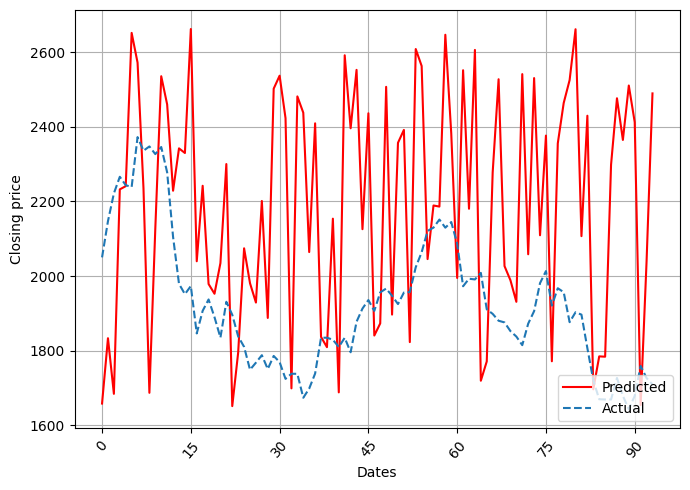

In [ ]:
for training_progr in epochs_training_progress_sQRNN:
  epochsDF = pd.DataFrame(training_progr.T, columns=['Predictions', 'Labels'])
  plot_predictions_and_labels(epochsDF['Predictions'], epochsDF['Labels'])

# labels_Train = np.array(labels_TRAIN)
# epochsDF = epochsDF.assign(Labels=np.reshape(labels_Train, -1))

# epochsDF.index = spy_data.Date[1:len(epochsDF.Labels)+1]

PLOT VALIDATION PROGRESS

In [ ]:
validDF = pd.DataFrame({'Predictions': valid_predictions_pQRNN, 'Labels': valid_labels_pQRNN})
validDF.index = valid_index[7:]
fig_to_save = plot_predictions_and_labels(validDF['Predictions'], validDF['Labels'])

In [ ]:
save_plot_to_drive(fig_to_save, "pQRNN", "BKNG", "Close")

In [ ]:
validDF = pd.DataFrame({'Predictions': valid_predictions_sQRNN, 'Labels': valid_labels_sQRNN})
validDF.index = valid_index[7:]
fig_to_save=plot_predictions_and_labels(validDF['Predictions'], validDF['Labels'])

In [ ]:
save_plot_to_drive(fig_to_save, "pQRNN", "BKNG", "Close")

VALIDATION (inference)

In [ ]:
def inference(model, seven_day_vec, maxmin):
  print(f"Seven day data: {seven_day_vec}")

  prediction = postprocess_output(model.forward(seven_day_vec), maxmin[0], maxmin[1])
  
  print(f"Prediction for the eight day: {prediction}")

  return prediction

DEBUGGING AND RECHEKING PART, effectively appendix, not necessary to read past this point

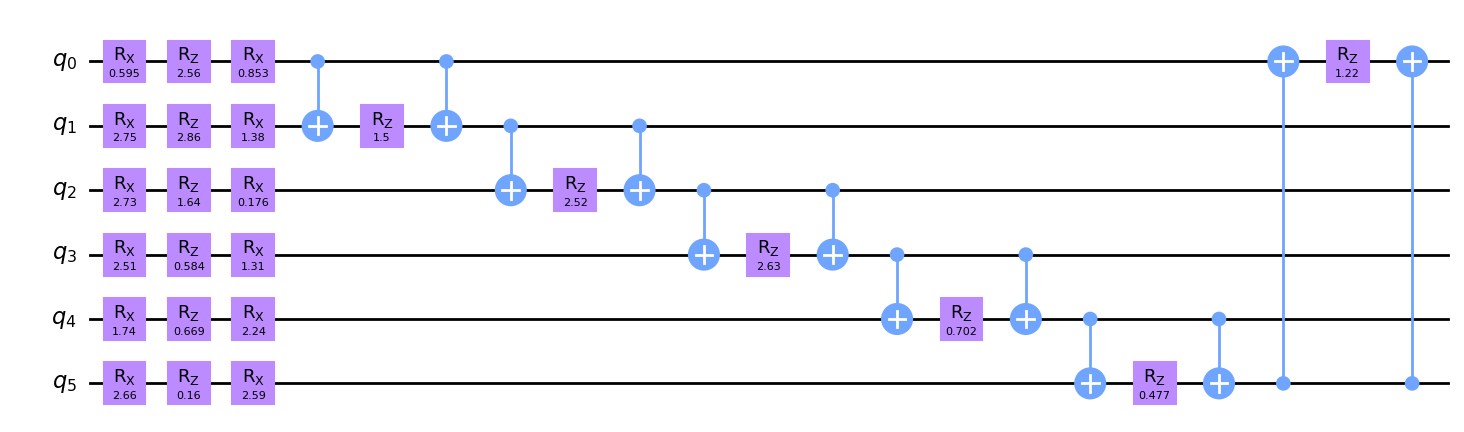

In [ ]:
ans = QRNN_model.construct_ansatz()
ans.draw("mpl")

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


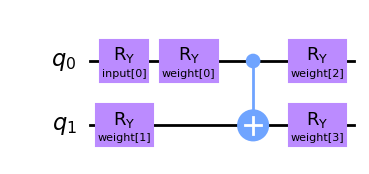

In [ ]:
from qiskit.circuit import ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
# qc2.ry(inputs2[1], 1)
# qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw(output="mpl")

In [ ]:
import numpy as np
from qiskit import *
from qiskit import Aer

backend = Aer.get_backend('unitary_simulator')
#prepare 2qubits
circ = QuantumCircuit(2)
circ.h(1)
circ.ch(1, 0)

job = execute(circ, backend)
result = job.result()
print(result.get_unitary(circ, decimals=3))

Operator([[ 0.707-0.j, -0.   +0.j,  0.707-0.j, -0.   +0.j],
          [ 0.   +0.j,  0.707+0.j,  0.   +0.j,  0.707-0.j],
          [ 0.5  -0.j,  0.5  -0.j, -0.5  +0.j, -0.5  +0.j],
          [ 0.5  +0.j, -0.5  -0.j, -0.5  +0.j,  0.5  -0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [ ]:
circuit = QuantumCircuit(2, 2)

# Add a H gate on qubit 0
# circuit.h(0)
# circuit.h(0)
# circuit.h(1)
# circuit.h(2)

# Add a CX (CNOT) gate on control qubit 0 and target qubit 1
# circuit.ch(1, 0)

circuit.h(1)

circuit.ch(1, 0)

circuit.draw()

┌───┐
q_0: ─────┤ H ├
     ┌───┐└─┬─┘
q_1: ┤ H ├──■──
     └───┘     
c: 2/══════════

In [ ]:
circ_dens_matrix = qi.DensityMatrix.from_instruction(circuit)

In [ ]:
circ_dens_matrix

DensityMatrix([[0.5       +0.j, 0.        +0.j, 0.35355339+0.j,
                0.35355339+0.j],
               [0.        +0.j, 0.        +0.j, 0.        +0.j,
                0.        +0.j],
               [0.35355339+0.j, 0.        +0.j, 0.25      +0.j,
                0.25      +0.j],
               [0.35355339+0.j, 0.        +0.j, 0.25      +0.j,
                0.25      +0.j]],
              dims=(2, 2))


In [ ]:
def fun(circuit):
  circ_dens_matrix = qi.DensityMatrix.from_instruction(circuit)
  qubits_to_trace_out = list(range(2))[:1]
  print(qubits_to_trace_out)

  measured_qubit_rho = qi.partial_trace(circ_dens_matrix, qubits_to_trace_out)

  ket1 = qi.Statevector([0, 1])
  projector1 = ket1.to_operator()

  trimmed_measured_qubit_rho = measured_qubit_rho.evolve(projector1)
  # return trimmed_measured_qubit_rho.trace()
  return measured_qubit_rho


In [ ]:
dm = fun(circuit)

[0]


In [ ]:
dm

DensityMatrix([[0.5       +0.j, 0.35355339+0.j],
               [0.35355339+0.j, 0.5       +0.j]],
              dims=(2,))


In [ ]:
y_t = fun(circuit)

In [ ]:
abs(y_t)

0.9999999999999993

In [ ]:
random_nums = [random.randint(200, 400) for i in range(1000)]